In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
import random
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Experiment 1 - Coupled Three Box

List of experiments:

a) Abrupt

b) High Emissions

c) Mid. Emissions

c) Overshoot

#### Setup and Run Experiments

In [2]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 2.25         # Noise strength

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Mid. Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs_ensemble[scen], forcings_ensemble[scen], T_out_ensemble[scen] = [], [] ,[]

  # Run deterministic scenarios once
  full_outputs_single[scen] = BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes, diff_flag=1)
  forcings_single[scen] = np.tile(full_outputs_single[scen]['forcing_ts'], (n_boxes, 1))
  T_out_single[scen] = np.squeeze(full_outputs_single[scen]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[scen].append(BudykoSellers.Run_Budyko_Sellers(scen_flag=i, xi=xi, n_boxes=n_boxes))
    forcings_ensemble[scen].append(np.tile(full_outputs_ensemble[scen][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[scen].append(np.squeeze(full_outputs_ensemble[scen][-1]['T_ts'])[0:n_boxes,:])


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:332: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Take mean over the entire ensemble (for calculations later)

In [3]:
mean_forcing, mean_T = {}, {}
for scen in scenarios:
  mean_forcing[scen] = np.mean(np.stack(forcings_ensemble[scen], axis=0), axis=0)
  mean_T[scen] = np.mean(np.stack(T_out_ensemble[scen], axis=0), axis=0)

### Method 1: Pattern Scaling

In [5]:
operator_PS, T_pred_PS, error_metrics_PS = emulator_utils.emulate_scenarios('PS', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single)
#emulator_utils.save_error(error_metrics_PS, 'exp2_1_PS_error_single')

Train: Abrupt - L2 Error
	Test: Abrupt - [24.03541522 10.1530938  12.04652802]
	Test: High Emissions - [101.00155896  25.12208279  22.69161337]
	Test: Mid. Emissions - [58.73905776 15.62500184 17.86044965]
	Test: Overshoot - [69.84280766 19.00163517 21.52862786]
Train: High Emissions - L2 Error
	Test: Abrupt - [47.69337921 21.3019306  20.53845525]
	Test: High Emissions - [1.24163869 0.31364331 0.33374451]
	Test: Mid. Emissions - [36.18224848 12.42079063  7.24214625]
	Test: Overshoot - [50.12073017 17.9845266   9.66118703]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [36.53051208 14.87876053 18.10833477]
	Test: High Emissions - [33.57281877 10.53530633  4.26117376]
	Test: Mid. Emissions - [24.59894709  7.51903312  6.12466631]
	Test: Overshoot - [42.42850534 13.88548869  9.73520807]
Train: Overshoot - L2 Error
	Test: Abrupt - [36.76063465 14.21512086 19.4107676 ]
	Test: High Emissions - [32.82593535 11.77848151  1.95763548]
	Test: Mid. Emissions - [24.60604818  7.60914588  6.47790153

In [6]:
NRMSE_base_PS = {}
for train in scenarios:
  NRMSE_base_PS[train] = {}
  for test in scenarios:
    if train == test:
      continue
    NRMSE_base_PS[train][test] = np.mean(error_metrics_PS[train][test])

In [4]:
import matplotlib.lines as mlines

def plot_ensemble_error(NRMSE_ens, NRMSE_base, scenarios, method, train, save=False, figname=None):

  fig, ax = plt.subplots(figsize=(8,8))
  xaxis = np.arange(1,51)

  extra = [mlines.Line2D([], [], color='k', linestyle='-',  label='Noisy', lw=2, alpha=0.6),
           mlines.Line2D([], [], color='k', linestyle='--', label='Noiseless', lw=2, alpha=0.6)]

  for i, scen in enumerate(scenarios):
    if train == scen:
      continue
    ax.semilogy(xaxis, NRMSE_ens[train][scen], lw=2, c=emulator_utils.brewer2_light(i), label=scen)
    ax.axhline(y=NRMSE_base[train][scen],lw=2,ls='--', c=emulator_utils.brewer2_light(i))

  ax.set_ylabel('NRMSE',fontsize=22)
  ax.set_xlabel('No. Ensemble Members',fontsize=22)
  ax.set_title(f'Error vs. Ensemble Size: {method}',fontsize=24)
  ax.tick_params(axis='both', which='major', labelsize=18)

  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles + extra, labels + [h.get_label() for h in extra], fontsize=20)

  if save:
    plt.savefig(f'Figures/ensemble_{figname}.pdf',dpi=900)

  return

In [39]:
def plot_ensemble_error_multi(NRMSE_all, NRMSE_all_base, scenarios, methods, train, save=False, figname=None):

  fig, ax = plt.subplots(2,2,figsize=(14,8),sharex=True,sharey='row',layout='constrained')
  xaxis = np.arange(1,51)

  extra = [mlines.Line2D([], [], color='k', linestyle='-',  label='Noisy', lw=2, alpha=0.6),
           mlines.Line2D([], [], color='k', linestyle='--', label='Noiseless', lw=2, alpha=0.6)]

  for i, ax in enumerate(ax.flat):
    NRMSE_ens = NRMSE_all[i]
    NRMSE_base = NRMSE_all_base[i]
    method = methods[i]
    for j, scen in enumerate(scenarios):
      if train == scen:
        continue
      ax.semilogy(xaxis, NRMSE_ens[train][scen], lw=2, c=emulator_utils.brewer2_light(j), label=scen)
      ax.axhline(y=np.mean(NRMSE_base[train][scen]),lw=2,ls='--', c=emulator_utils.brewer2_light(j))

    ax.set_title(f'{method}',fontsize=18)
    ax.grid()

    if i == 0:
      ax.legend(fontsize=16)
      handles, labels = ax.get_legend_handles_labels()
      ax.legend(handles + extra, labels + [h.get_label() for h in extra], fontsize=16)

  ax.tick_params(axis='both', which='major', labelsize=18)

  fig.supylabel(r'NRMSE [\%]',fontsize=24)
  fig.supxlabel('No. Ensemble Members',fontsize=24)
  fig.suptitle(f'NRMSE vs. Ensemble Size by Method, Train = {train}',fontsize=24)

  if save:
    plt.savefig(f'Figures/exp2_ensemble_{figname}.pdf',dpi=900)

  return

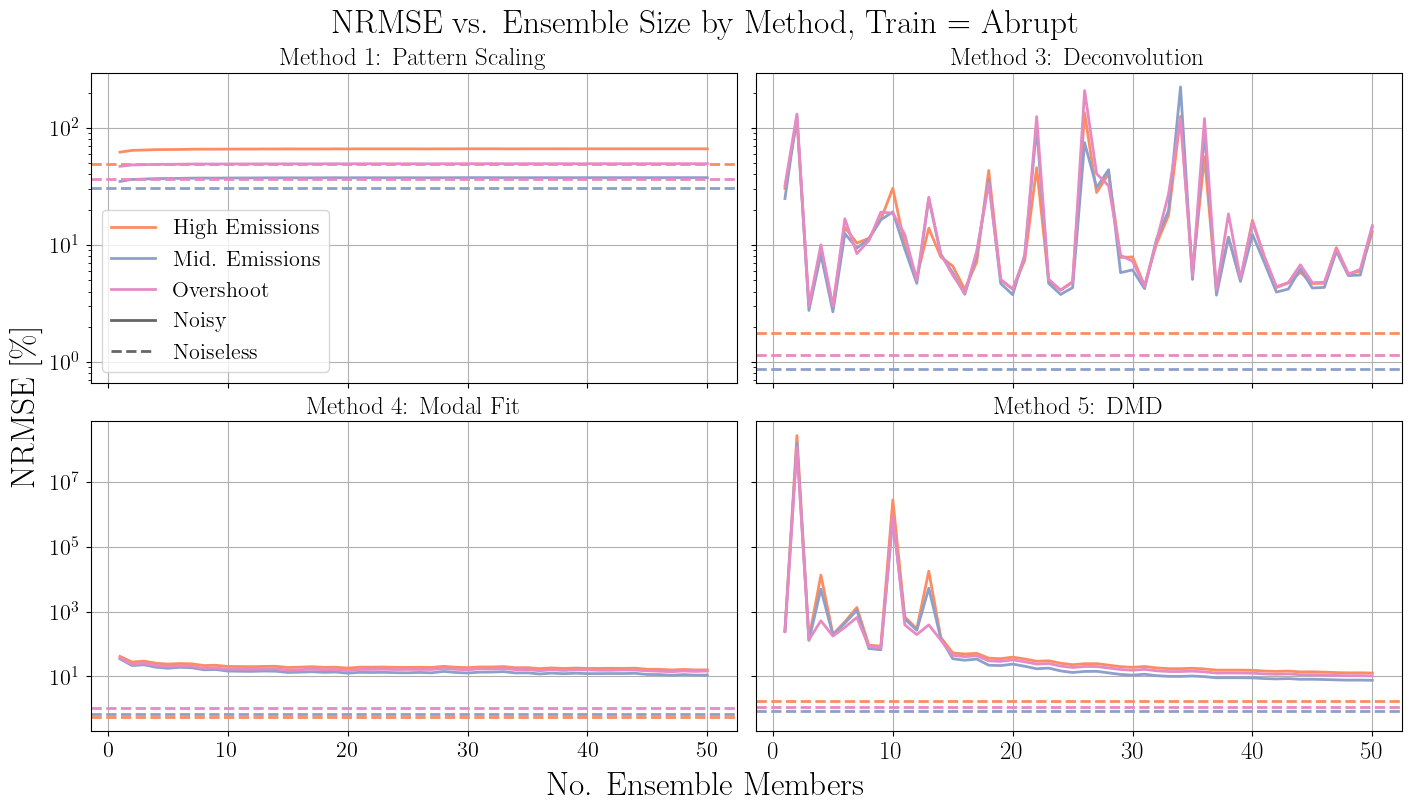

In [40]:
NRMSE_all_PS, NRMSE_base_PS = emulator_utils.open_error('exp2_1_PS_error_ensemble'), emulator_utils.open_error('exp2_1_PS_error_single')
NRMSE_all_deconv, NRMSE_base_deconv = emulator_utils.open_error('exp2_3_deconv_error_ensemble'), emulator_utils.open_error('exp2_3_deconv_error_single')
NRMSE_all_fit, NRMSE_base_fit = emulator_utils.open_error('exp2_4_fit_error_ensemble'), emulator_utils.open_error('exp2_4_fit_error_single')
NRMSE_all_DMD, NRMSE_base_DMD = emulator_utils.open_error('exp2_5_DMD_error_ensemble'), emulator_utils.open_error('exp2_5_DMD_error_single')
NRMSE_all = [NRMSE_all_PS,NRMSE_all_deconv,NRMSE_all_fit,NRMSE_all_DMD]
NRMSE_all_base = [NRMSE_base_PS,NRMSE_base_deconv,NRMSE_base_fit,NRMSE_base_DMD]
methods = ['Method 1: Pattern Scaling','Method 3: Deconvolution',
           'Method 4: Modal Fit', 'Method 5: DMD']
train = 'Abrupt'
plot_ensemble_error_multi(NRMSE_all, NRMSE_all_base, scenarios, methods, train, save=True, figname='all')

In [28]:
n_choices = 10

NRMSE_all_PS = {}
for train in scenarios:
  NRMSE_all_PS[train] = {}
  forcing_and_T = list(zip(forcings_ensemble[train], T_out_ensemble[train]))

  for test in scenarios:
    if train == test:
      continue

    NRMSE_all_PS[train][test] = []

  for n in range(1, n_ensemble + 1):
    NRMSE_temp = {}
    for test in scenarios:
      if train == test:
        continue

      NRMSE_temp[test] = []

    for _ in range(n_choices):
      # Choose n ensemble members
      temp_choice = random.sample(forcing_and_T, n)
      forcing_choice, T_choice = zip(*temp_choice)

      # Calculate operator
      operator_temp = emulator_utils.method_0_PS(np.mean(T_choice, axis=0))

      for test in scenarios:
        if train == test:
          continue
        # Calculate error tested against the full ensemble (i.e. avg. forcing)
        T_pred_temp = emulator_utils.emulate_PS(mean_T[test], operator_temp)
        NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(mean_T[test], T_pred_temp)))

    # Save average error over trials
    for test in scenarios:
      if train == test:
        continue
      NRMSE_all_PS[train][test].append(np.mean(NRMSE_temp[test]))


In [18]:
emulator_utils.save_error(NRMSE_all_PS, 'exp2_1_PS_error_ensemble')

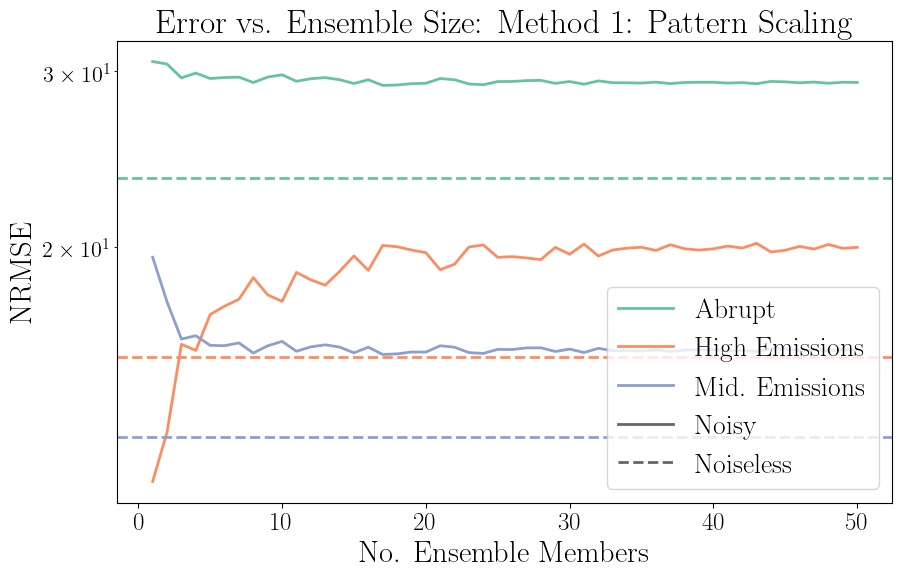

In [30]:
plot_ensemble_error(NRMSE_all_PS, NRMSE_base_PS, scenarios, 'Method 1: Pattern Scaling', 'Overshoot', save=False, figname='PS')

### Method 5: Dynamic Mode Decomposition (DMD)

In [15]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, error_metrics_DMD = emulator_utils.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
emulator_utils.save_error(error_metrics_DMD, 'exp2_5_DMD_error_single')

Train: Abrupt - L2 Error
	Test: Abrupt - [0.01411515 0.11245775 0.03193134]
	Test: High Emissions - [1.69468558 1.90812405 1.69473636]
	Test: Mid. Emissions - [1.07611365 0.80806719 0.74608034]
	Test: Overshoot - [1.14240959 1.19177959 1.09117541]
Train: High Emissions - L2 Error
	Test: Abrupt - [1.15693446 1.20301885 1.08339567]
	Test: High Emissions - [0.00099809 0.00439681 0.00127167]
	Test: Mid. Emissions - [0.76585386 1.20512289 1.08717717]
	Test: Overshoot - [1.07356938 1.90363974 1.70774114]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.36540574 1.90528808 0.76541857]
	Test: High Emissions - [0.02927111 0.07756085 0.03795411]
	Test: Mid. Emissions - [0.00714897 0.01616286 0.01088341]
	Test: Overshoot - [0.01422484 0.02935802 0.02664737]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.35577186 3.72017009 0.88402659]
	Test: High Emissions - [0.02487544 0.14378837 0.03499499]
	Test: Mid. Emissions - [0.00340725 0.0242712  0.005833  ]
	Test: Overshoot - [0.00034082 0.00054131 0

In [16]:
NRMSE_base_DMD = {}
for train in scenarios:
  NRMSE_base_DMD[train] = {}
  for test in scenarios:
    NRMSE_base_DMD[train][test] = np.mean(error_metrics_DMD[train][test])

In [11]:
n_choices = 10

NRMSE_all_DMD = {}
for train in scenarios:
  NRMSE_all_DMD[train] = {}
  forcing_and_T = list(zip(forcings_ensemble[train], T_out_ensemble[train]))

  for test in scenarios:
    if train == test:
      continue

    NRMSE_all_DMD[train][test] = []

  for n in range(1, n_ensemble + 1):
    NRMSE_temp = {}
    for test in scenarios:
      if train == test:
        continue

      NRMSE_temp[test] = []

    for _ in range(n_choices):
      # Choose n ensemble members
      temp_choice = random.sample(forcing_and_T, n)
      forcing_choice, T_choice = zip(*temp_choice)

      # Calculate operator
      A_temp, B_temp = emulator_utils.method_1a_DMD(np.mean(T_choice, axis=0), np.mean(forcing_choice, axis=0))

      for test in scenarios:
        if train == test:
          continue
        # Calculate error tested against the full ensemble (i.e. avg. forcing)
        T_pred_temp = emulator_utils.emulate_DMD(mean_forcing[test], A_temp, B_temp, w0, n_steps)
        NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(mean_T[test], T_pred_temp)))

    # Save average error over trials
    for test in scenarios:
      if train == test:
        continue
      NRMSE_all_DMD[train][test].append(np.mean(NRMSE_temp[test]))


In [23]:
emulator_utils.save_error(NRMSE_all_DMD, 'exp2_5_DMD_error_ensemble')

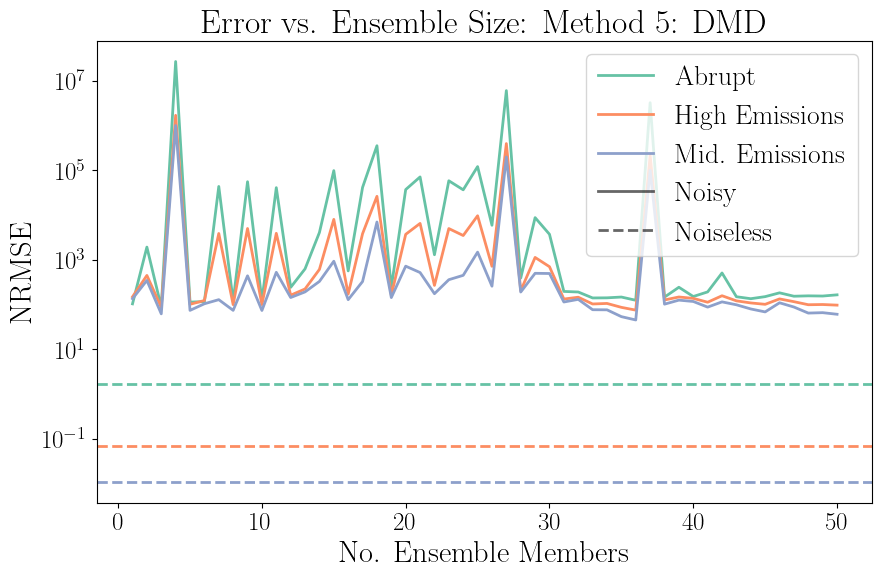

In [17]:
plot_ensemble_error(NRMSE_all_DMD, NRMSE_base_DMD, scenarios, 'Method 5: DMD', 'Overshoot', save=False, figname='DMD')

### Method 6: EDMD

In [19]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=2)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=2)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = emulator_utils.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
emulator_utils.save_error(error_metrics_EDMD, 'exp2_6_EDMD_error_single')

Train: Abrupt - L2 Error
	Test: Abrupt - [0.01430924 0.11256044 0.03214935]
	Test: High Emissions - [ 66.47606023 101.95704016  91.45921254]
	Test: Mid. Emissions - [43.39365486 31.58901127 33.04090657]
	Test: Overshoot - [44.5328645  33.61304868 33.21478733]
Train: High Emissions - L2 Error
	Test: Abrupt - [14.33779888 14.47527596 24.85669917]
	Test: High Emissions - [0.00159557 0.00446267 0.00184456]
	Test: Mid. Emissions - [12.87506414 11.11029288 18.55220214]
	Test: Overshoot - [16.72445481 15.59181607 26.17765934]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [0.44666928 0.49676709 0.42411551]
	Test: High Emissions - [1.06505637 2.74012858 2.19250407]
	Test: Mid. Emissions - [0.00024348 0.00102082 0.0006249 ]
	Test: Overshoot - [0.47949182 1.16717658 1.00987727]
Train: Overshoot - L2 Error
	Test: Abrupt - [0.36125846 4.95178424 0.93623061]
	Test: High Emissions - [0.02687385 0.19301854 0.04302314]
	Test: Mid. Emissions - [0.00491601 0.03311722 0.00889259]
	Test: Overshoot - [1.

In [20]:
NRMSE_base_EDMD = {}
for train in scenarios:
  NRMSE_base_EDMD[train] = {}
  for test in scenarios:
    NRMSE_base_EDMD[train][test] = np.mean(error_metrics_EDMD[train][test])

In [23]:
n_choices = 20

NRMSE_all_EDMD = {}
for train in scenarios:
  NRMSE_all_EDMD[train] = {}
  forcing_and_T = list(zip(forcings_ensemble[train], T_out_ensemble[train]))

  for test in scenarios:
    if train == test:
      continue

    NRMSE_all_EDMD[train][test] = []

  for n in range(1, n_ensemble + 1):
    NRMSE_temp = {}
    for test in scenarios:
      if train == test:
        continue

      NRMSE_temp[test] = []

    for _ in range(n_choices):
      # Choose n ensemble members
      temp_choice = random.sample(forcing_and_T, n)
      forcing_choice, T_choice = zip(*temp_choice)

      # Calculate operator
      A_temp, B_temp = emulator_utils.method_1b_EDMD(np.mean(T_choice, axis=0), np.mean(forcing_choice, axis=0), w_dict, F_dict)

      for test in scenarios:
        if train == test:
          continue
        # Calculate error tested against the full ensemble (i.e. avg. forcing)
        T_pred_temp = emulator_utils.emulate_EDMD(mean_forcing[test], A_temp, B_temp, w0, n_steps, n_boxes, w_dict, F_dict)
        NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(mean_T[test], T_pred_temp)))

    # Save average error over trials
    for test in scenarios:
      if train == test:
        continue
      NRMSE_all_EDMD[train][test].append(np.mean(NRMSE_temp[test]))


In [25]:
emulator_utils.save_error(NRMSE_all_EDMD, 'exp2_6_EDMD_error_ensemble')

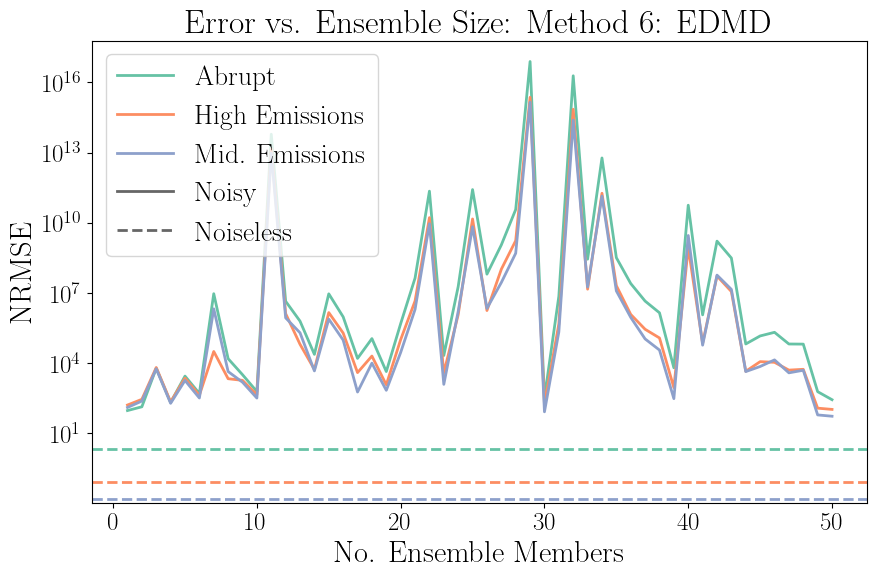

In [24]:
plot_ensemble_error(NRMSE_all_EDMD, NRMSE_base_EDMD, scenarios, 'Method 6: EDMD', 'Overshoot', save=False, figname='EDMD')

### Method 3: Deconvolution

In [ ]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = emulator_utils.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, dt=dt, regularize=True)
#emulator_utils.save_error(error_metrics_deconvolve, 'exp2_3_deconv_error_single')

Train: Abrupt - L2 Error


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


	Test: Abrupt - [0.02220472 0.8853311  0.20344347]
	Test: High Emissions - [1.60846307 2.0290934  1.65987106]
	Test: Mid. Emissions - [1.03440708 0.86339668 0.74101939]
	Test: Overshoot - [1.102685   1.28510364 1.08389458]
Train: High Emissions - L2 Error
	Test: Abrupt - [0.92373828 3.39104651 1.61021921]
	Test: High Emissions - [0.00788126 0.09034811 0.02745916]
	Test: Mid. Emissions - [0.52800277 2.84207449 1.52900583]
	Test: Overshoot - [0.73118197 4.54561011 2.41681146]
Train: Mid. Emissions - L2 Error
	Test: Abrupt - [7.65843245 8.98874355 1.12415698]
	Test: High Emissions - [0.89158889 0.42873309 0.04950084]
	Test: Mid. Emissions - [0.00741223 0.04992336 0.00956796]
	Test: Overshoot - [0.26010284 0.33204829 0.02252007]
Train: Overshoot - L2 Error
	Test: Abrupt - [15.67396197  9.5664979   2.25422781]
	Test: High Emissions - [2.88678262 2.11683709 0.4646772 ]
	Test: Mid. Emissions - [1.25747491 0.55515676 0.19141154]
	Test: Overshoot - [0.11461986 0.54214086 0.1970388 ]


In [ ]:
NRMSE_base_deconvolve = {}
for train in scenarios:
  NRMSE_base_deconvolve[train] = {}
  for test in scenarios:
    NRMSE_base_deconvolve[train][test] = np.mean(error_metrics_deconvolve[train][test])

In [5]:
n_choices = 10
n_ensemble = 50

NRMSE_all_deconvolve = {}
for train in scenarios:
  NRMSE_all_deconvolve[train] = {}
  forcing_and_T = list(zip(forcings_ensemble[train], T_out_ensemble[train]))

  for test in scenarios:
    if train == test:
      continue

    NRMSE_all_deconvolve[train][test] = []

  for n in range(1, n_ensemble + 1):
    NRMSE_temp = {}
    for test in scenarios:
      if train == test:
        continue

      NRMSE_temp[test] = []

    for _ in range(n_choices):
      # Choose n ensemble members
      temp_choice = random.sample(forcing_and_T, n)
      forcing_choice, T_choice = zip(*temp_choice)

      # Calculate operator
      G_temp = emulator_utils.method_3a_deconvolve(np.mean(T_choice, axis=0), np.mean(forcing_choice, axis=0), dt, regularize=False)

      for test in scenarios:
        if train == test:
          continue
        # Calculate error tested against the full ensemble (i.e. avg. forcing)
        T_pred_temp = emulator_utils.emulate_response(mean_forcing[test], G_temp, dt)
        NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(mean_T[test], T_pred_temp)))

    # Save average error over trials
    for test in scenarios:
      if train == test:
        continue
      NRMSE_all_deconvolve[train][test].append(np.mean(NRMSE_temp[test]))


NameError: name 'dt' is not defined

In [10]:
#emulator_utils.save_error(NRMSE_all_deconvolve, 'exp2_3_deconv_error_ensemble')

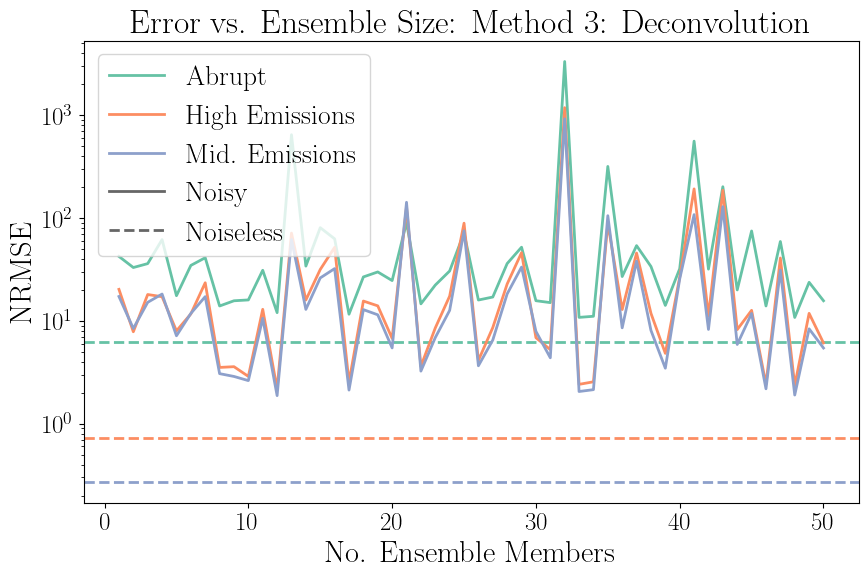

In [ ]:
plot_ensemble_error(NRMSE_all_deconvolve, NRMSE_base_deconvolve, scenarios, 'Method 3: Deconvolution', 'Overshoot', save=False, figname='deconv')

### Method 4: Exponential Fit

In [47]:
operator_fit, T_pred_fit, error_metrics_fit = emulator_utils.emulate_scenarios('fit_amp', scenarios=scenarios, outputs=T_out_single, forcings=forcings_single, t=t, dt=dt, n_boxes=n_boxes, n_modes=3, B=np.ones(n_boxes))
emulator_utils.save_error(error_metrics_fit, 'exp2_4_fit_error_single')

Train: Abrupt - L2 Error
[  4.7615447 -13.721515  -12.566678   -6.028455    0.5519342 -10.654598
  -8.01522   -12.623155    2.56636    -4.9786983  -0.5315595  -2.098566 ]
	Test: Abrupt - [0.5377967  1.68661342 2.04147938]
	Test: High Emissions - [0.70778211 0.42163185 0.53512598]
	Test: Mid. Emissions - [0.51264508 1.0451288  0.46872943]
	Test: Overshoot - [0.6358754  1.44691638 1.15167484]
Train: High Emissions - L2 Error
[  5.0099053 -13.829879  -13.546732  -10.234516    1.2535075 -11.19875
 -11.184166  -13.199723    3.6821585  -6.919219   -1.2304647  -3.5853207]
	Test: Abrupt - [30.29055335 10.36492187 35.94885729]
	Test: High Emissions - [0.9268688 1.3026399 0.6569955]
	Test: Mid. Emissions - [ 6.67048389  3.38133977 27.84111181]
	Test: Overshoot - [ 8.12830774  5.48796893 41.09932372]
Train: Mid. Emissions - L2 Error
[  4.8257756 -13.805718  -13.536577   -6.633925    1.3362448 -11.217675
 -11.057173  -13.07963     2.735623   -5.2191544  -1.2368438  -2.308746 ]
	Test: Abrupt - [5.2

In [57]:
NRMSE_base_fit = {}
for train in scenarios:
  NRMSE_base_fit[train] = {}
  for test in scenarios:
    NRMSE_base_fit[train][test] = np.mean(error_metrics_fit[train][test])

In [58]:
n_choices = 10
n_ensemble = 50
n_boxes = 3
n_modes = 3

NRMSE_all_fit = {}
for train in scenarios:
  NRMSE_all_fit[train] = {}
  forcing_and_T = list(zip(forcings_ensemble[train], T_out_ensemble[train]))

  for test in scenarios:
    if train == test:
      continue

    NRMSE_all_fit[train][test] = []

  for n in range(1, n_ensemble + 1):
    NRMSE_temp = {}
    for test in scenarios:
      if train == test:
        continue

      NRMSE_temp[test] = []

    for _ in range(n_choices):
      # Choose n ensemble members
      temp_choice = random.sample(forcing_and_T, n)
      forcing_choice, T_choice = zip(*temp_choice)

      # Calculate operator
      G_temp = emulator_utils.method_4c_fit_amp(np.mean(T_choice, axis=0), np.mean(forcing_choice, axis=0), t, dt, n_modes, n_boxes)

      for test in scenarios:
        if train == test:
          continue
        # Calculate error tested against the full ensemble (i.e. avg. forcing)
        T_pred_temp = emulator_utils.emulate_response(mean_forcing[test], G_temp, dt)
        NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(mean_T[test], T_pred_temp)))

    # Save average error over trials
    for test in scenarios:
      if train == test:
        continue
      NRMSE_all_fit[train][test].append(np.mean(NRMSE_temp[test]))

    emulator_utils.save_error(NRMSE_all_fit, 'exp2_4_fit_error_ensemble')


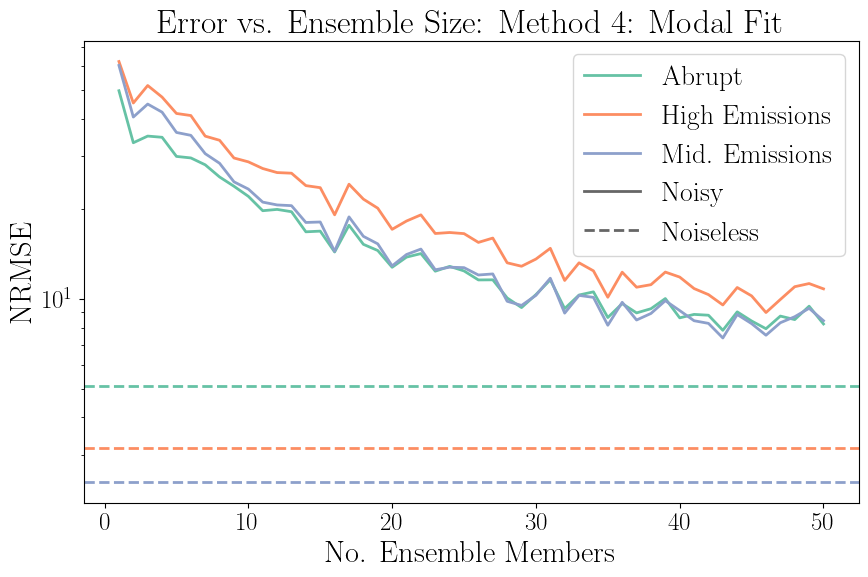

In [60]:
plot_ensemble_error(NRMSE_all_fit, NRMSE_base_fit, scenarios, 'Method 4: Modal Fit', 'Overshoot', save=False, figname='fit')